In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip  '/content/drive/MyDrive/Capstone.zip'

Archive:  /content/drive/MyDrive/Capstone.zip
   creating: Capstone/
   creating: Capstone/test/
   creating: Capstone/test/BrownSpot/
  inflating: Capstone/test/BrownSpot/IMG_3066_13_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3077_18_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3081_19_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3165_26_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_3244_45_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_4831_47_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_4864_52_11zon.jpg  
  inflating: Capstone/test/BrownSpot/IMG_4904_56_11zon.jpg  
  inflating: Capstone/test/BrownSpot/shape 108 .jpg  
  inflating: Capstone/test/BrownSpot/shape 11 .jpg  
  inflating: Capstone/test/BrownSpot/shape 114 .jpg  
  inflating: Capstone/test/BrownSpot/shape 145 .jpg  
  inflating: Capstone/test/BrownSpot/shape 149 .jpg  
  inflating: Capstone/test/BrownSpot/shape 158 .jpg  
  inflating: Capstone/test/BrownSpot/shape 200 .jpg  


In [3]:
#https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/
#https://keras.io/api/applications/efficientnet/ 
#https://vigneshgig.medium.com/xception-neural-network-transfer-learning-and-data-processing-using-ai-c3e7a4ea7bf2 

In [4]:
#pip install split-folders tqdm

In [5]:
import tensorflow as tf
import numpy as np
# import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Split Dataset into 3 part: Train, Val, and Test

In [6]:
# splitfolders.ratio(
#     base_dir,
#     output='Capstone',
#     ratio=(.8,0.1,0.1)
# )

In [7]:
train_dir = 'Capstone/train'
val_dir = 'Capstone/val' 
test_dir = 'Capstone/test'
os.listdir(train_dir)

['LeafBlast', 'Healthy', 'Hispa', 'BrownSpot']

In [8]:
class_name = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=0.45,
                    brightness_range=(0.8,1.2), 
                    shear_range=0.2, 
                    zoom_range=(0.5,1.0), 
                    fill_mode='nearest', 
                    horizontal_flip=True,
                    vertical_flip=True,
                    )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224,224), 
    batch_size=32, 
    shuffle=True,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 1811 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 230 images belonging to 4 classes.


Modeling

In [11]:
from keras.callbacks import EarlyStopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=3)

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [13]:
from tensorflow.keras.applications import Xception
tfmodel = Xception(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224,224,3))
# tfmodel.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [14]:
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

In [15]:
model = Sequential()
model.add(tfmodel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))      
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [17]:
history = model.fit(train_generator,
                    epochs=50,
                    callbacks=[monitor_val_acc,reduce_lr],
                    shuffle=True,
                    verbose=True,
                    validation_data=validation_generator)

Epoch 1/50
57/57 [==============================] - 63s 768ms/step - loss: 1.3663 - accuracy: 0.3087 - val_loss: 1.3011 - val_accuracy: 0.4330 - lr: 1.0000e-04
Epoch 2/50
57/57 [==============================] - 38s 661ms/step - loss: 1.1764 - accuracy: 0.4804 - val_loss: 1.0455 - val_accuracy: 0.6027 - lr: 1.0000e-04
Epoch 3/50
57/57 [==============================] - 40s 697ms/step - loss: 0.9243 - accuracy: 0.6262 - val_loss: 0.7881 - val_accuracy: 0.6920 - lr: 1.0000e-04
Epoch 4/50
57/57 [==============================] - 40s 697ms/step - loss: 0.7611 - accuracy: 0.7151 - val_loss: 0.7998 - val_accuracy: 0.7232 - lr: 1.0000e-04
Epoch 5/50
57/57 [==============================] - 38s 663ms/step - loss: 0.6933 - accuracy: 0.7670 - val_loss: 0.7137 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 6/50
57/57 [==============================] - 39s 682ms/step - loss: 0.5762 - accuracy: 0.7940 - val_loss: 0.6221 - val_accuracy: 0.7768 - lr: 1.0000e-04
Epoch 7/50
57/57 [======================

In [18]:
model.save("Model.h5")

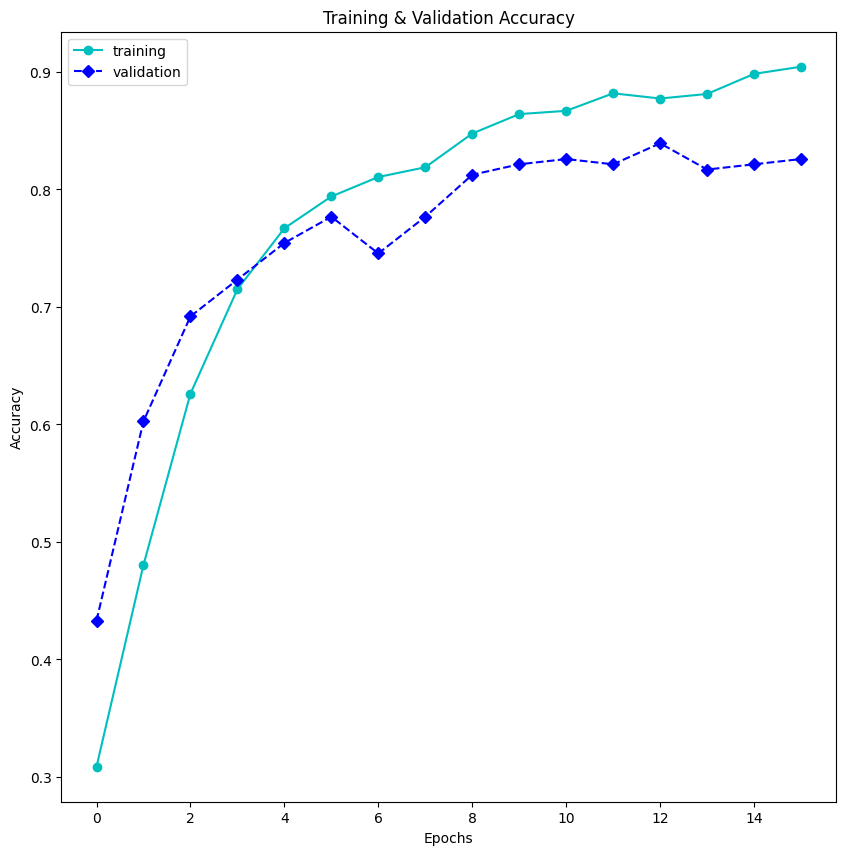

In [19]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'bD--',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

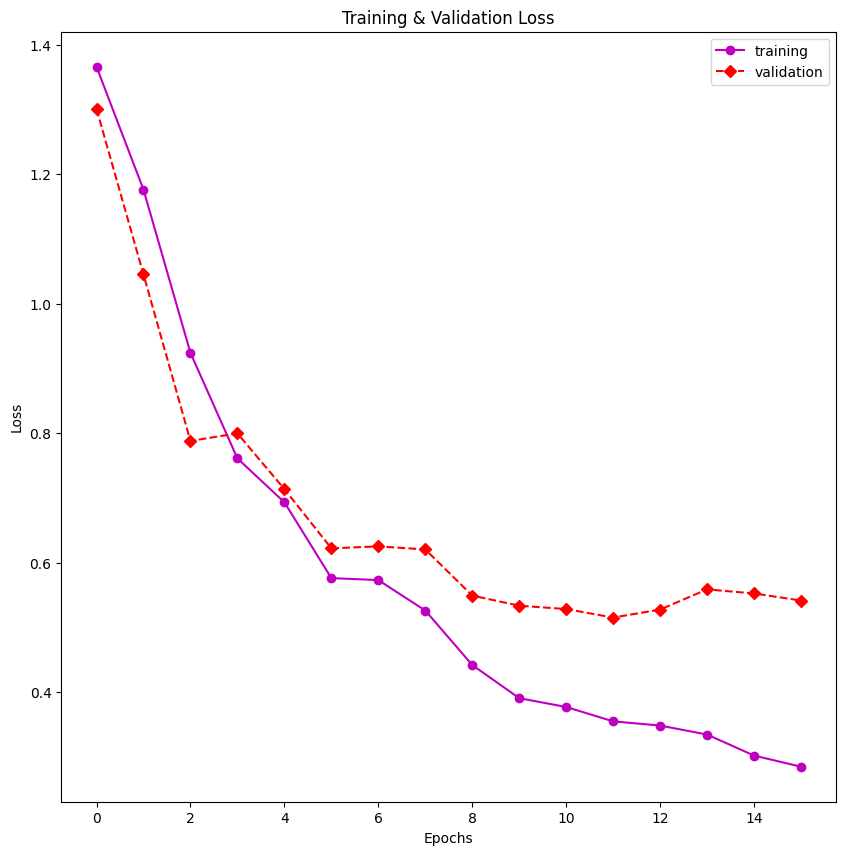

In [20]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
         'mo-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'rD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [21]:
test_evaluate = model.evaluate(test_generator)

print(f'Test loss     : {test_evaluate[0]}')
print(f'Test accuracy : {round(test_evaluate[1],2)}')

8/8 [==============================] - 2s 241ms/step - loss: 0.3900 - accuracy: 0.8696
Test loss     : 0.38995760679244995
Test accuracy : 0.87


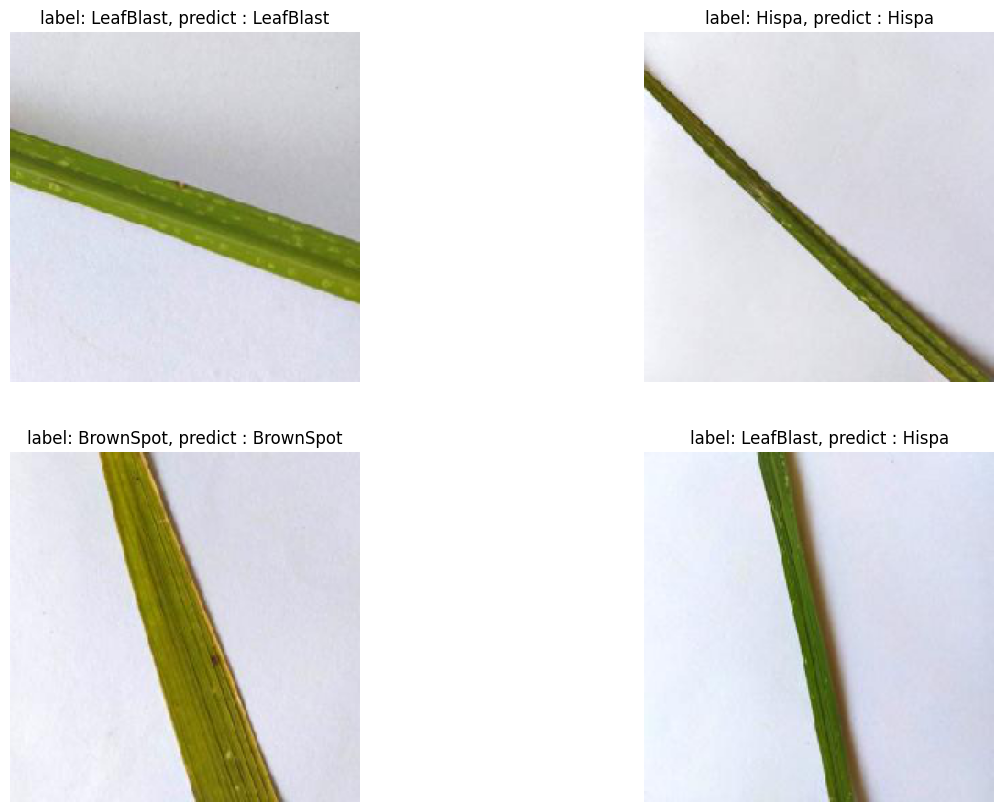

In [22]:
image ,label = next(iter(test_generator))

plt.figure(figsize=(15,10))
for i in range(4) :
    TrueLabel = class_name[np.argmax(label[i])]
    plt.subplot(2,2,i+1)
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0))
    plt.imshow(tf.squeeze(image[i]))
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}')